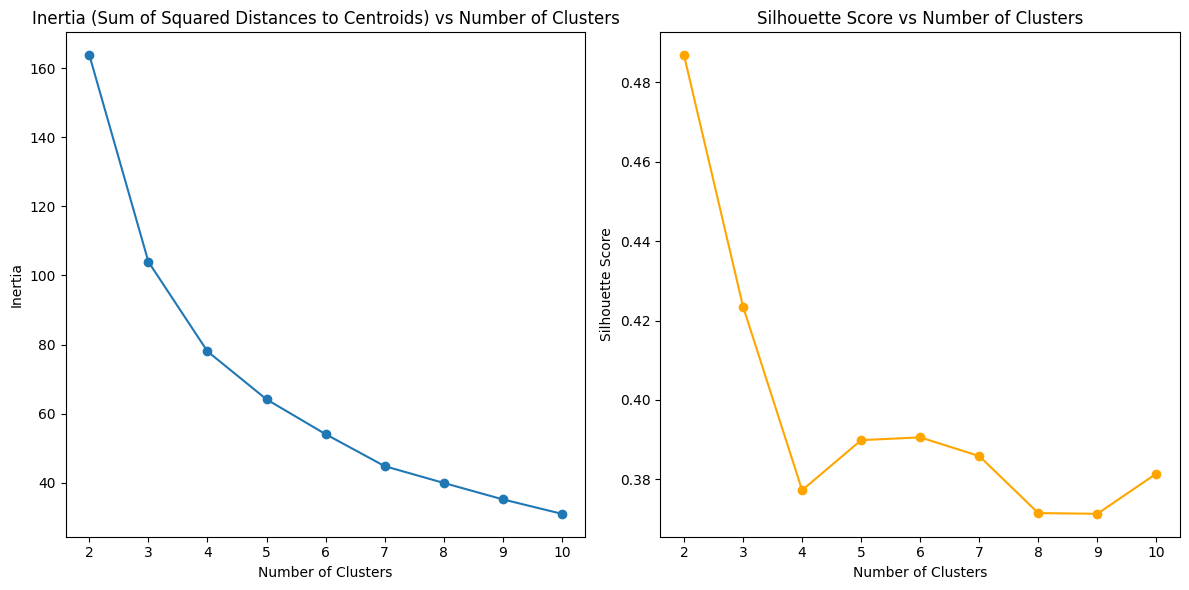

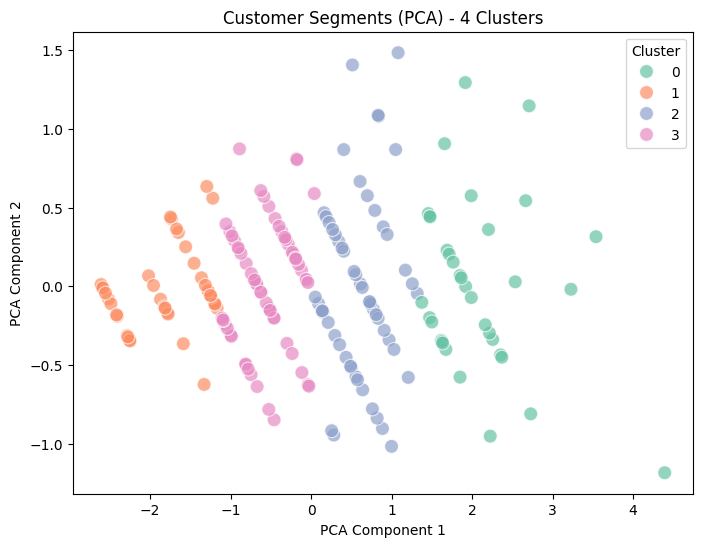

Optimal number of clusters: 4
Davies-Bouldin Index: 0.8595340221510472
Silhouette Score: 0.37724079925410997


In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load data
customers_df = pd.read_csv("Customers.csv")
transactions_df = pd.read_csv("Transactions.csv")

# Step 2: Data Preparation and Merging
merged_df = pd.merge(customers_df, transactions_df, on="CustomerID")

# Step 3: Feature Engineering
# 1. Calculate purchase frequency
merged_df["purchase_frequency"] = merged_df.groupby("CustomerID")["TransactionID"].transform("count")

# 2. Calculate recency (days since last purchase)
merged_df["last_purchase_day"] = (
    merged_df.groupby("CustomerID")["TransactionDate"].transform(pd.to_datetime).max()
    - pd.to_datetime("today")
).days

# 3. Calculate total purchase amount
merged_df["total_purchase_amount"] = merged_df.groupby("CustomerID")["TotalValue"].transform("sum")

customer_data = merged_df.drop_duplicates("CustomerID")[["CustomerID", "purchase_frequency", "last_purchase_day", "total_purchase_amount"]]

# Step 4: Data Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data[["purchase_frequency", "last_purchase_day", "total_purchase_amount"]])

# Step 5: Clustering - KMeans (You can experiment with other algorithms)
inertia = [] 
silhouette_scores = []  
db_indexes = [] 

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    
    # Calculate metrics
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))
    db_indexes.append(davies_bouldin_score(scaled_data, kmeans.labels_))

# Step 6: Plot the Inertia and Silhouette Score to help determine the optimal number of clusters
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Inertia (Sum of Squared Distances to Centroids) vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Step 7: Select the optimal number of clusters based on metrics
optimal_k = 4 
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_data)

# Step 8: Assign cluster labels to the customer data (only customer-level data)
customer_data["cluster"] = kmeans.labels_

# Step 9: Merge cluster labels back into the original dataframe
merged_df = merged_df.merge(customer_data[["CustomerID", "cluster"]], on="CustomerID", how="left")

# Step 10: Cluster Visualization using PCA (2D representation)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=customer_data["cluster"], palette="Set2", s=100, alpha=0.7)
plt.title(f'Customer Segments (PCA) - {optimal_k} Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# Step 11: Report the Clustering Metrics
print(f"Optimal number of clusters: {optimal_k}")
print(f"Davies-Bouldin Index: {db_indexes[optimal_k - 2]}")
print(f"Silhouette Score: {silhouette_scores[optimal_k - 2]}")


